<a href="https://colab.research.google.com/github/R1dhoeee/Deeplearning/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install dan Import library
!pip install gdown

import gdown
import zipfile
import shutil
import random
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import regularizers


In [ ]:
# 2. Download dataset dari Google Drive (gunakan direct link)
file_id = "1Nls_gsE6Nq5hpCBW09o_on8_k924Ityz"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Nls_gsE6Nq5hpCBW09o_on8_k924Ityz
From (redirected): https://drive.google.com/uc?id=1Nls_gsE6Nq5hpCBW09o_on8_k924Ityz&confirm=t&uuid=9729597a-603a-49f0-bc49-f95d31c97e2c
To: /content/dataset.zip
100%|██████████| 54.5M/54.5M [00:01<00:00, 37.0MB/s]


'dataset.zip'

In [ ]:
# 3. Ekstrak zip
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [ ]:
# 4. Split Data sesuai template kamu
original_dataset_dir = Path("dataset/Foto Resizeee")
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder split
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.2
test_split = 0.1

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        train_images = images[:train_count]
        val_images = images[train_count:train_count+val_count]
        test_images = images[train_count+val_count:]

        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)


In [ ]:
# 5. Data Augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



In [ ]:
# 6. Bangun Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Base model ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

# 2. Fine-tune sebagian layer (misalnya 50 layer terakhir)
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# 3. Arsitektur tambahan yang dalam
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# 4. Bangun dan compile model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 5. Callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

# 6. Train dengan maksimal 50 epoch
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Sesuai permintaan dosen
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_913']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 349ms/step - accuracy: 0.2998 - loss: 1.8233 - val_accuracy: 0.2946 - val_loss: 1.3847 - learning_rate: 1.0000e-04
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.3477 - loss: 1.6078 - val_accuracy: 0.3195 - val_loss: 1.3276 - learning_rate: 1.0000e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.4120 - loss: 1.4320 - val_accuracy: 0.3029 - val_loss: 1.2746 - learning_rate: 1.0000e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.5255 - loss: 1.0954 - val_accuracy: 0.3402 - val_loss: 1.2996 - learning_rate: 1.0000e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.5452 - loss: 1.0462 - val_accuracy: 0.3444 - val_loss: 1.2906 - learning_rate: 1.0000e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.5827 - loss: 0.9949 - val_accuracy: 0.3278 - val_loss: 1.3760 - learning_rate: 1.0000e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.64

Saving 20250415_164609.jpg to 20250415_164609.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_913']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Gambar: 20250415_164609.jpg
Prediksi: KEYBOARD MCHOOSE


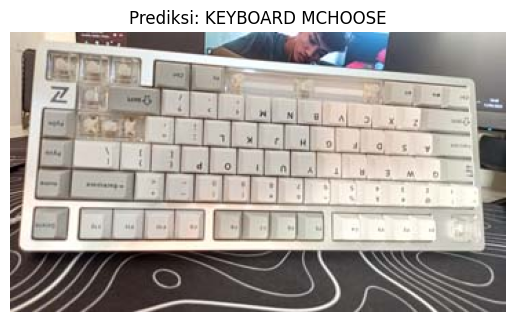

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

# Upload gambar dari lokal
uploaded = files.upload()

for fname in uploaded.keys():
    img_path = fname
    img = image.load_img(img_path, target_size=(224, 224))  # sesuai input model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # normalisasi

    # Prediksi
    pred = model.predict(img_array)
    predicted_class = np.argmax(pred[0])
    class_names = list(train_generator.class_indices.keys())

    print(f"Gambar: {fname}")
    print(f"Prediksi: {class_names[predicted_class]}")

    # Tampilkan gambar
    plt.imshow(Image.open(img_path))
    plt.title(f"Prediksi: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()


In [ ]:
# 9. Evaluasi
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.9507 - loss: 0.1620
Test Accuracy: 96.67%


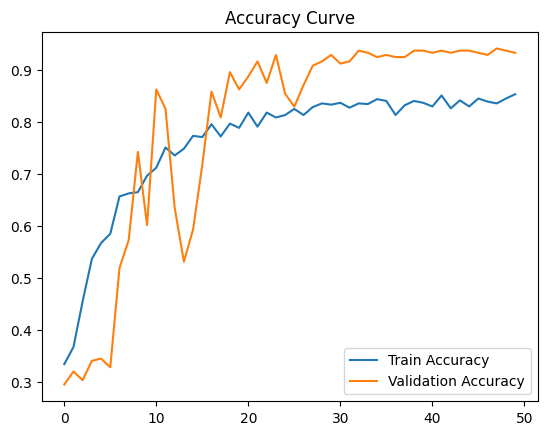

In [ ]:
# 10. Visualisasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_913']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_913']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 545ms/step


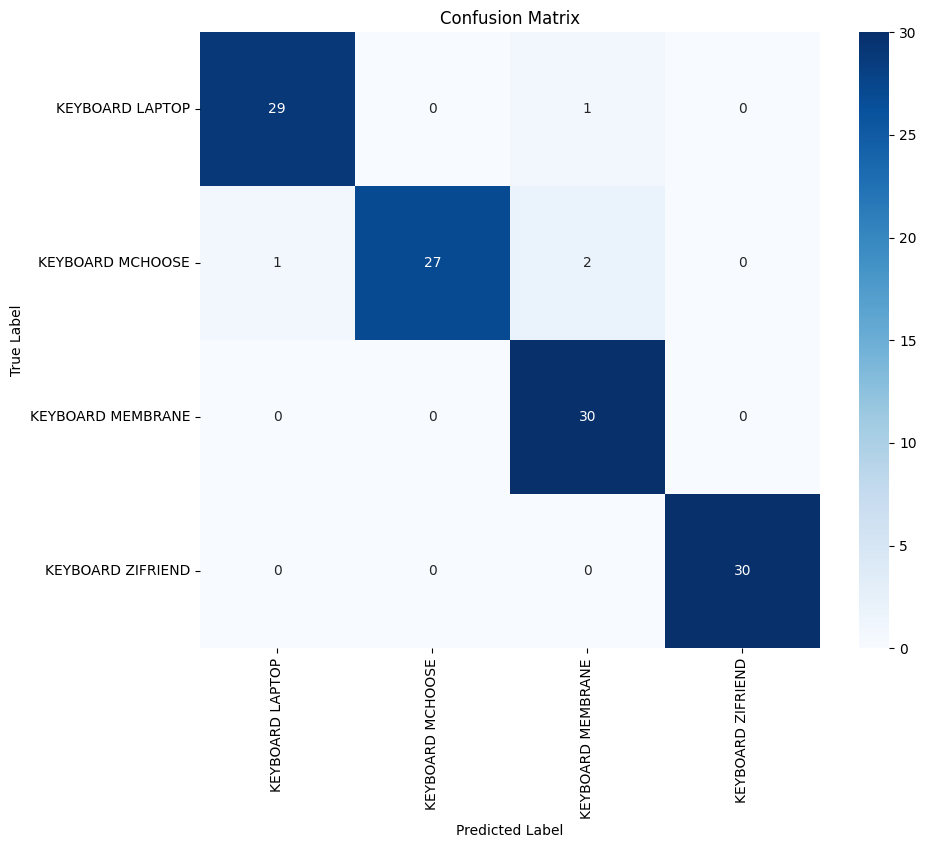


Classification Report:
                   precision    recall  f1-score   support

  KEYBOARD LAPTOP       0.97      0.97      0.97        30
 KEYBOARD MCHOOSE       1.00      0.90      0.95        30
KEYBOARD MEMBRANE       0.91      1.00      0.95        30
KEYBOARD ZIFRIEND       1.00      1.00      1.00        30

         accuracy                           0.97       120
        macro avg       0.97      0.97      0.97       120
     weighted avg       0.97      0.97      0.97       120



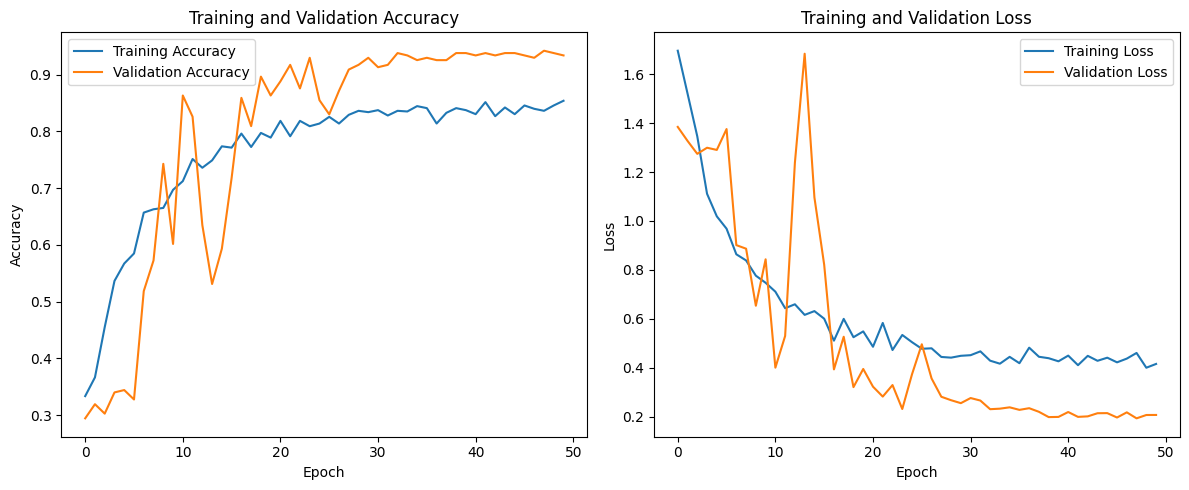

In [ ]:
#Evaluasi model dengan confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

#Prediksi pada data test
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

#Dapatkan true classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

#Buat confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#Print classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

#Grafik akurasi dan loss yang lebih lengkap
plt.figure(figsize=(12, 5))

#Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()